In [70]:
! pip install tensorflow scikit-learn torch torchvision pennylane

In [71]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pennylane as qml

In [72]:
# Paths

dataset_dir="experiment-ii"
labels_dir="experiment-ii_labels.csv"

In [73]:
# Load the label mappings
labels_df = pd.read_csv(labels_dir)
print("✅ Labels Loaded:", labels_df.shape)

✅ Labels Loaded: (465, 4)


In [74]:
# Extract unique labels and map them to integers
unique_labels = sorted(labels_df["Label"].unique())  # Get all unique postures
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

print("🔹 Label Mapping:", label_mapping)  # Example: {'Supine': 0, 'Right': 1, 'Left': 2, ...}

🔹 Label Mapping: {'Left': 0, 'Right': 1, 'Supine': 2}


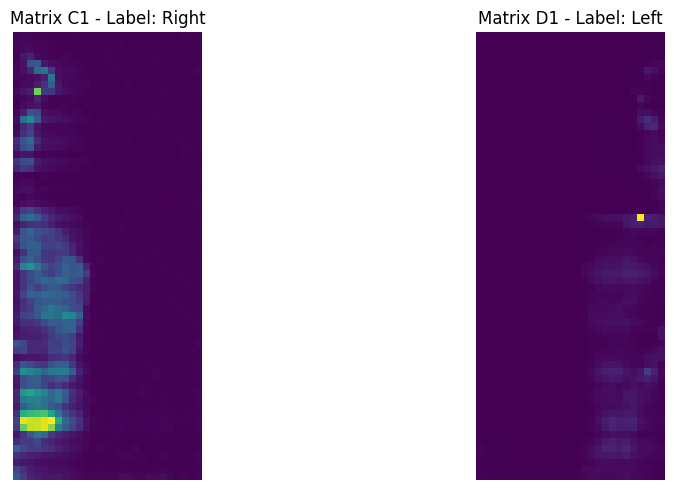

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def load_pressure_matrix(file_path):
    return np.loadtxt(file_path)

def get_label(file_name):
    row = labels_df[labels_df["File_Name"].str.contains(file_name, case=False)]
    if not row.empty:
        return row["Label"].values[0]
    return "Unknown"

# Define file paths
file_C1 = "experiment-ii/S1/Air_Mat/Matrix_Air_C1.txt"
file_D1 = "experiment-ii/S1/Air_Mat/Matrix_Air_D1.txt"

# Load matrices
matrix_C1 = load_pressure_matrix(file_C1)
matrix_D1 = load_pressure_matrix(file_D1)

# Get labels
label_C1 = get_label("C1")
label_D1 = get_label("D1")

# Plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(matrix_C1, cmap='viridis')
axs[0].set_title(f"Matrix C1 - Label: {label_C1}")
axs[0].axis("off")

axs[1].imshow(matrix_D1, cmap='viridis')
axs[1].set_title(f"Matrix D1 - Label: {label_D1}")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [76]:
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.Resize((64, 64)),  # Resize to QCNN input shape
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize between -1 and 1
])


In [94]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader, random_split
import pennylane as qml
import joblib


# ---------------------- CONFIG ----------------------
root_dir = "experiment-ii"
label_csv_path ="experiment-ii_labels.csv"
num_qubits = 11
num_layers = 5
batch_size = 32

# ---------------------- LOAD LABELS ----------------------
label_df = pd.read_csv(label_csv_path)
label_mapping = {label: idx for idx, label in enumerate(sorted(label_df['Label'].unique()))}

# ---------------------- CUSTOM DATASET ----------------------
class PressureMatrixDataset(Dataset):
    def __init__(self, root_dir, label_df, num_qubits):
        self.data = []
        self.labels = []
        self.file_paths = []  # ✅ store the full file path for each sample

        for _, row in label_df.iterrows():
            subject = row['Subject']
            mat_type = row['Mat_Type']
            file_name = row['File_Name']
            label = row['Label']

            txt_path = os.path.join(root_dir, subject, mat_type, file_name.replace('.png', '.txt'))
            if not os.path.isfile(txt_path):
                continue

            matrix = np.loadtxt(txt_path)
            flat_matrix = matrix.flatten().astype(np.float32)

            self.data.append(flat_matrix)
            self.labels.append(label)
            self.file_paths.append(txt_path)  # ✅ Add the path to the list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            data = self.data[idx]
            label = self.labels[idx]
            return torch.tensor(data, dtype=torch.float32), label
        except Exception as e:
            print(f"❌ Error at index {idx}: {e}")
            raise

# Build file paths and labels
raw_data = []
raw_labels = []
file_paths = []

for _, row in label_df.iterrows():
    subject = row['Subject']
    mat_type = row['Mat_Type']
    file_name = row['File_Name']
    label = row['Label']

    txt_path = os.path.join("experiment-ii", subject, mat_type, file_name.replace(".png", ".txt"))
    if os.path.isfile(txt_path):
        matrix = np.loadtxt(txt_path)
        flat = matrix.flatten().astype(np.float32)
        raw_data.append(flat)
        raw_labels.append(label)
        file_paths.append(txt_path)
        
# Apply PCA
pca = PCA(n_components=11)
data_pca = pca.fit_transform(raw_data)
joblib.dump(pca, "pca_model.pkl")
print("✅ PCA model saved.")

✅ PCA model saved.


In [78]:
# ---------------------- INIT DATASET & DATALOADER ----------------------
dataset = PressureMatrixDataset(root_dir, label_df, num_qubits)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check sizes
print(f"✅ Trainset Size: {len(train_dataset)}")
print(f"✅ Testset Size: {len(test_dataset)}")


✅ Trainset Size: 372
✅ Testset Size: 93


In [79]:
class QuantumCircuit:
    def __init__(self, num_qubits, num_layers):
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(num_qubits))
            for _ in range(num_layers):
                qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

        self.circuit = circuit

    def __call__(self, inputs, weights):
        return self.circuit(inputs, weights)

In [80]:
# ---------------------- QCNN Model ----------------------
class QCNN(nn.Module):
    def __init__(self, num_qubits, num_layers):
        super().__init__()
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.q_params = nn.Parameter(0.01 * torch.randn(num_layers, num_qubits, 3))
        self.qcircuit = QuantumCircuit(num_qubits, num_layers)
        self.fc1 = nn.Linear(num_qubits, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        quantum_outputs = [torch.tensor(self.qcircuit(x[i], self.q_params), dtype=torch.float32) for i in range(x.shape[0])]
        x = torch.stack(quantum_outputs)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.3)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [81]:
model = QCNN(num_qubits=num_qubits, num_layers=num_layers).to(device)
print("\n📦 Model Parameters:")
for name, param in model.named_parameters():
    print(f"{name} -> {param.shape}")


📦 Model Parameters:
q_params -> torch.Size([5, 11, 3])
fc1.weight -> torch.Size([64, 11])
fc1.bias -> torch.Size([64])
fc2.weight -> torch.Size([32, 64])
fc2.bias -> torch.Size([32])
fc3.weight -> torch.Size([4, 32])
fc3.bias -> torch.Size([4])


In [82]:
# ---------------------- Save Model Weights ----------------------
def save_model_weights():
    model = QCNN(num_qubits=11, num_layers=5)
    torch.save(model.state_dict(), 'qcnn1_model_weights.pth')
    print("✅ Model weights saved as 'qcnn1_model.pth'")

save_model_weights()

✅ Model weights saved as 'qcnn1_model.pth'


In [83]:
# ---------------------- TRAINING LOOP ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QCNN(num_qubits=num_qubits, num_layers=num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total = 0
    correct = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    scheduler.step()
    epoch_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

print("✅ Training Completed!")

Epoch [1/10] - Loss: 1.3267, Training Accuracy: 58.87%
Epoch [2/10] - Loss: 1.3034, Training Accuracy: 58.87%
Epoch [3/10] - Loss: 1.2781, Training Accuracy: 58.87%
Epoch [4/10] - Loss: 1.2522, Training Accuracy: 58.87%
Epoch [5/10] - Loss: 1.2258, Training Accuracy: 58.87%
Epoch [6/10] - Loss: 1.1970, Training Accuracy: 58.87%
Epoch [7/10] - Loss: 1.1667, Training Accuracy: 58.87%
Epoch [8/10] - Loss: 1.1412, Training Accuracy: 58.87%
Epoch [9/10] - Loss: 1.1084, Training Accuracy: 58.87%
Epoch [10/10] - Loss: 1.0827, Training Accuracy: 58.87%
✅ Training Completed!


In [85]:
# Assume `model` is your trained QCNN instance
torch.save(model.state_dict(), "qcnn1_model.pth")
print("✅ Trained QCNN model  saved as 'qcnn1_model.pth'")


✅ Trained QCNN model  saved as 'qcnn1_model.pth'


In [86]:
# -------------------------TESTING LOOP-----------------------------
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long).to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

test_losses.append(avg_test_loss)
test_accuracies.append(test_accuracy)

print(f"✅ Final Test Loss: {avg_test_loss:.4f}")
print(f"✅ Final Test Accuracy: {test_accuracy:.2f}%")


✅ Final Test Loss: 1.1087
✅ Final Test Accuracy: 55.91%


📊 Classification Report:


d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        Left       0.00      0.00      0.00        18
       Right       0.00      0.00      0.00        23
      Supine       0.56      1.00      0.72        52

    accuracy                           0.56        93
   macro avg       0.19      0.33      0.24        93
weighted avg       0.31      0.56      0.40        93



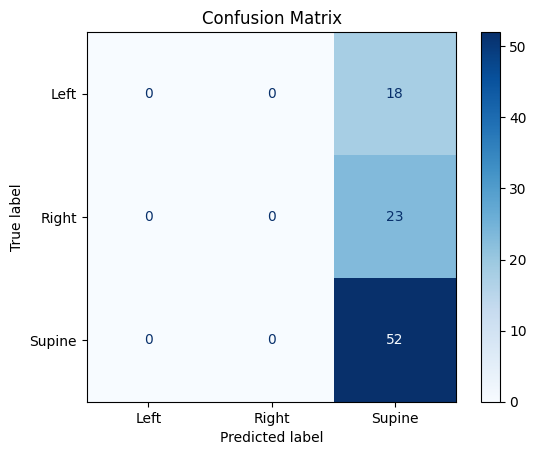

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_mapping.keys()))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


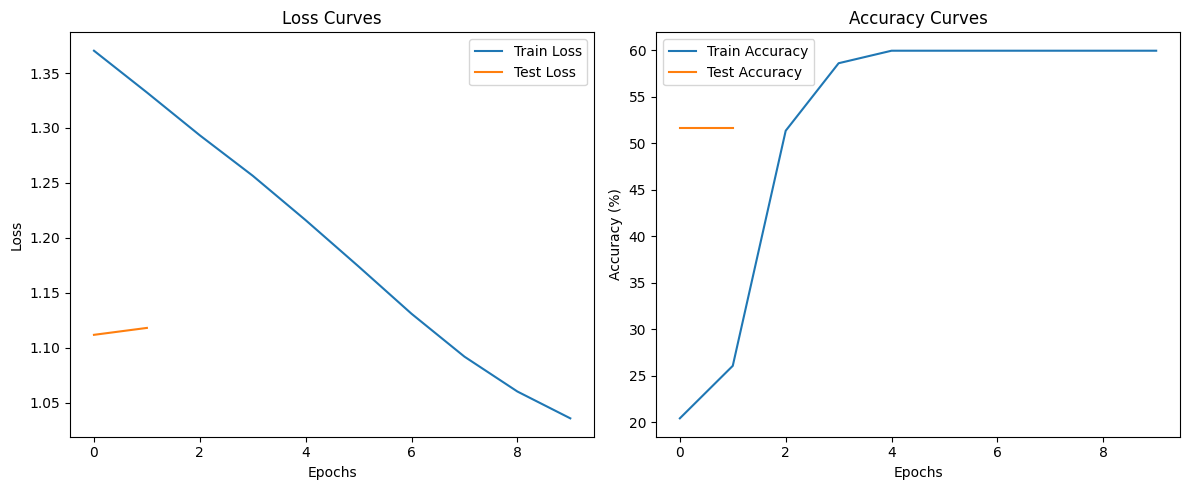

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


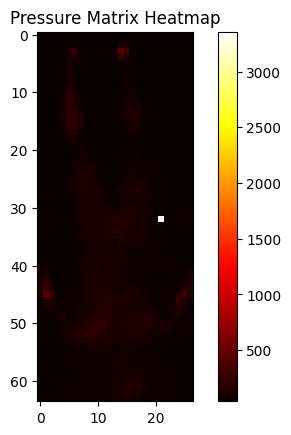

Predicted Posture: Supine


In [99]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import joblib

# Load PCA model
pca = joblib.load("pca_model.pkl")

# Prediction function
def predict_from_file(file_path):
    matrix = np.loadtxt(file_path)
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.title("Pressure Matrix Heatmap")
    plt.colorbar()
    plt.show()

    # Normalize and apply PCA
    matrix_scaled = MinMaxScaler().fit_transform(matrix).flatten()
    matrix_pca = pca.transform([matrix_scaled])[0]
    input_tensor = torch.tensor(matrix_pca, dtype=torch.float32).unsqueeze(0)

    # Match model exactly as trained
    model = QCNN(11, 5)
    model.load_state_dict(torch.load("qcnn1_model.pth", map_location=torch.device('cpu')))
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    label_mapping = {label: idx for idx, label in enumerate(sorted(label_df['Label'].unique()))}
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    print(f"Predicted Posture: {reverse_label_mapping[pred]}")
    

# Example usage
predict_from_file("D:/QCNN/experiment-ii/S6/Sponge_Mat/Matrix_Sponge_B2.txt")